<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/docs/reproduction_paper_fig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# command line
以下のpipセクション終了後に必ず**ランタイムの再起動**を行うこと

In [1]:
!pip install scanpy scikit-misc

# install ldvae
!git clone https://github.com/kicysh/final_task_of_world_model_lecture_2021/
!pip install final_task_of_world_model_lecture_2021/package/. --use-feature=in-tree-build

     |████████████████████████████████| 2.0 MB 7.4 MB/s 
     |████████████████████████████████| 8.8 MB 41.3 MB/s 
     |████████████████████████████████| 96 kB 5.9 MB/s 
     |████████████████████████████████| 11.2 MB 55.0 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 899 kB 65.8 MB/s 
     |████████████████████████████████| 1.1 MB 52.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=cd49ea897e5dc024863c2a17cd9f9a71b7cef647a585dad0e575d3b4839d65c9
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=a748d3e82ad66114a258f4c9476dd7466f60419b5be292d003bc85d76fea5813
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created 

Cloning into 'final_task_of_world_model_lecture_2021'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 169 (delta 36), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (169/169), 14.24 MiB | 7.12 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Processing ./final_task_of_world_model_lecture_2021/package
  Created wheel for LDVAE: filename=LDVAE-0.0.0-py3-none-any.whl size=3270 sha256=b59a63d5aefef4abd31f976f1b6ed92d2c393018a15098ef46c1d8dbf26600a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9khrdnjz/wheels/e2/2f/44/da18d64c7ac8950bd4f266d145db33398678d80aff1a4f488f
Successfully built LDVAE


In [1]:
!mkdir data figures intermediate
!gsutil cp gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad /content/data


Copying gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad...
- [1 files][  1.0 GiB/  1.0 GiB]   61.2 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


In [2]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
anndata                       0.8.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4   

# setting


In [1]:
# global
USE_CUDA = True

# model params
SETTING_HIDDEN_DIMS = (128,)
SETTING_LATENT_DIM = 20


SETTING_BATCH_SIZE = 1024

SETTING_N_TOP_GENES = 1000

SETTING_TRAIN_RATE = 0.8
SETTING_VAL_RATE = 0.2

DATA_PATH = '/content/data/pijuan_sala_atlas.h5ad'
W_CSV_PATH = '/content/intermediate/w.csv'
Z_CSV_PATH = '/content/intermediate/z.csv'

RANDOM_SEED = 42

In [2]:
import ldvae

import numpy as np
import pandas as pd

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import logsumexp
from torch.distributions import Normal, kl_divergence

import matplotlib.pyplot as plt

import scanpy as sc


In [3]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

GENERATOR = torch.Generator()
GENERATOR.manual_seed(RANDOM_SEED)

# data

## read data

In [4]:
adata = sc.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 139331 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name'

## 前処理

In [5]:
idx = adata.obs.query('not doublet').index
adata = adata[idx]
sc.pp.highly_variable_genes(adata,n_top_genes=1000 ,flavor='seurat_v3')
print(adata)


/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


AnnData object with n_obs × n_vars = 125775 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'


In [6]:
gene_index = adata.var[adata.var['highly_variable']].index
adata_df = adata.to_df()[gene_index]


## create dataset

In [7]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata: np.array, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        return data

## create dataloader

In [8]:
# dataloder
dataset = GenesDataset(adata_df.values)

n_samples = len(dataset) 
train_size = int(n_samples* SETTING_TRAIN_RATE)
val_size = int(n_samples * SETTING_VAL_RATE)
test_size = n_samples - train_size - val_size 

dataset_train ,dataset_valid, dataset_test = \
        torch.utils.data.random_split(dataset, [train_size, val_size,test_size])

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    generator=GENERATOR
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    generator=GENERATOR
)


# model

## define model

In [9]:
model = ldvae.LDVAE(genes_cnt = len(adata_df.columns),
                    hidden_dims=SETTING_HIDDEN_DIMS,
                    latent_dim = SETTING_LATENT_DIM)
model.set_local_l_mean_and_var(adata_df.values)
model

LDVAE(
  (encoder_z): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_z_mean): Linear(in_features=128, out_features=20, bias=True)
  (encoder_z_var): Linear(in_features=128, out_features=20, bias=True)
  (encoder_l): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_l_mean): Linear(in_features=128, out_features=1, bias=True)
  (encoder_l_var): Linear(in_features=128, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=1000, bias=False)
    (1): BatchNorm1d(1000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
)

## train

In [10]:

n_epochs  = 100
optimizer = optim.Adam(model.parameters(), lr=7e-3)

device = 'cuda'  if USE_CUDA else 'cpu'
model.to(device)

for epoch in range(n_epochs):
    losses = []

    model.train()
    for x in dataloader_train:
        x = x.to(device)

        #model.zero_grad()
        optimizer.zero_grad()
        # forawrd and loss
        reconst, kl_l ,kl_z = model.loss(x)
        loss = torch.mean(-reconst+kl_l +kl_z)

        #nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())

    losses_val1 = []
    losses_val2 = []
    losses_val3 = []

    model.eval()
    for x in dataloader_valid:

        x = x.to(device)
        reconst, kl_l ,kl_z = model.loss(x)

        losses_val1.append(torch.mean(-reconst).cpu().detach().numpy())
        losses_val2.append(torch.mean(kl_l).cpu().detach().numpy())
        losses_val3.append(torch.mean(kl_z).cpu().detach().numpy())

    print('EPOCH: %d    Train Loss: %lf    Valid rec: %lf    Valid kl_l: %lf    Valid kl_z: %lf' %
            (epoch+1, np.average(losses),np.average(losses_val1),np.average(losses_val2),np.average(losses_val3)))


EPOCH: 1    Train Loss: 1700.921875    Valid rec: 1112.676758    Valid kl_l: 5.150150    Valid kl_z: 14.534245
EPOCH: 2    Train Loss: 811.472961    Valid rec: 887.211975    Valid kl_l: 2.161402    Valid kl_z: 13.048495
EPOCH: 3    Train Loss: 705.469238    Valid rec: 750.788696    Valid kl_l: 1.583858    Valid kl_z: 12.862885
EPOCH: 4    Train Loss: 650.835266    Valid rec: 646.622925    Valid kl_l: 1.425641    Valid kl_z: 12.993926
EPOCH: 5    Train Loss: 618.991394    Valid rec: 589.658936    Valid kl_l: 1.288432    Valid kl_z: 13.100445
EPOCH: 6    Train Loss: 595.961426    Valid rec: 563.802979    Valid kl_l: 1.348420    Valid kl_z: 12.796591
EPOCH: 7    Train Loss: 579.110413    Valid rec: 550.995911    Valid kl_l: 1.245809    Valid kl_z: 12.879023
EPOCH: 8    Train Loss: 568.389343    Valid rec: 539.527893    Valid kl_l: 1.394031    Valid kl_z: 13.113692
EPOCH: 9    Train Loss: 559.135193    Valid rec: 534.022644    Valid kl_l: 1.233541    Valid kl_z: 14.111794
EPOCH: 10    Trai

# output intermediate files

## output weight

In [11]:
# w
import pandas as pd

_w = model.decoder[0].weight
bn = model.decoder[1]
sigma = torch.sqrt(bn.running_var + bn.eps)
gamma = bn.weight
b = gamma / sigma
bI = torch.diag(b)
loadings = torch.matmul(bI, _w)
loadings = loadings.detach().cpu().numpy()

W = pd.DataFrame(loadings, index=gene_index)
W.to_csv(W_CSV_PATH)


## output the latent variables (z)

In [12]:
# z
latent_array  = None
model.eval()
for x in dataloader_all:
    x = x.to(device)
    _z,_,_ = model(x)
    z_mean,_,_ = _z
    z_mean = z_mean.cpu().detach().numpy()
    if latent_array is None:
        latent_array = z_mean
    else:
        latent_array = np.concatenate([latent_array, z_mean])
pd.DataFrame(latent_array,index=adata_df.index).to_csv(Z_CSV_PATH)

# output figures

In [15]:
%pylab inline
%config InlineBackend.figure_format ='retina'

import time

import anndata
import matplotlib.colors as mcolors

import plotnine as p


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
w_df = pd.read_csv(W_CSV_PATH, index_col=0)
z_df = pd.read_csv(Z_CSV_PATH, index_col=0)

w_df = w_df.add_prefix('w')
z_df = z_df.add_prefix('z')

print('w_df====================')
print(w_df.head())
print('z_df====================')
print(z_df.head())

w_df====================
                          w0        w1        w2        w3        w4  \
index                                                                  
ENSMUSG00000025902  0.882152 -0.904588  0.437501  0.747310  0.122051   
ENSMUSG00000025927 -0.232108  0.491247  0.890256 -1.012900  0.077956   
ENSMUSG00000026124 -0.725410  0.036297 -0.381174  0.647260  0.241437   
ENSMUSG00000026043 -0.019143 -0.170355  0.101901 -1.269624 -0.604479   
ENSMUSG00000045954  0.084863  0.215434 -0.251367 -1.234664 -0.083858   

                          w5        w6        w7        w8        w9  \
index                                                                  
ENSMUSG00000025902  0.162200  0.382719  0.179952 -0.535569  0.013175   
ENSMUSG00000025927  0.955385  0.301862  0.168497  0.508806 -0.949872   
ENSMUSG00000026124 -0.212431  0.051102  0.076115 -0.067255  0.802500   
ENSMUSG00000026043  0.127212 -0.173998  0.092510 -0.405438 -0.629794   
ENSMUSG00000045954 -0.066814 -0.168502

In [16]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [17]:
_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]


In [18]:
Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index

In [19]:
adata = anndata.read(DATA_PATH)

In [19]:
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)

In [20]:
def make_kde(x1, x2):
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f


In [21]:
metadata = adata.obs.loc[Z_df_ordered.index]
metadata = metadata.join(Z_df_ordered)

for ctype in np.unique(metadata['celltype']):
    z_corrs = Z_df_ordered.corrwith((metadata['celltype'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head(3)
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)
    
vardata = W_df_ordered

[' z2: +0.22', ' z4: +0.18', 'z18: -0.18'] Allantois
[' z9: -0.21', 'z18: +0.14', 'z12: +0.13'] Anterior Primitive Streak
['z10: +0.21', ' z0: +0.16', 'z13: -0.12'] Blood progenitors 1
['z10: +0.35', 'z14: +0.20', ' z0: +0.16'] Blood progenitors 2
[' z7: +0.41', ' z4: -0.33', ' z2: +0.29'] Cardiomyocytes
[' z6: +0.16', 'z18: -0.12', ' z9: -0.07'] Caudal Mesoderm
[' z6: +0.23', 'z18: -0.17', 'z12: -0.15'] Caudal epiblast
[' z6: +0.13', 'z12: -0.08', 'z11: +0.08'] Caudal neurectoderm
[' z9: -0.22', 'z18: +0.12', ' z2: +0.11'] Def. endoderm
[' z0: +0.43', 'z13: -0.19', 'z16: -0.15'] Endothelium
['z14: -0.54', ' z8: -0.35', 'z10: -0.21'] Epiblast
['z14: +0.26', 'z15: -0.24', ' z1: +0.19'] Erythroid1
['z14: +0.19', 'z15: -0.17', ' z8: -0.14'] Erythroid2
['z14: +0.34', 'z15: -0.31', ' z8: -0.25'] Erythroid3
['z15: +0.66', ' z8: -0.49', 'z14: +0.26'] ExE ectoderm
['z19: -0.81', ' z1: +0.35', 'z15: +0.33'] ExE endoderm
['z18: -0.23', 'z12: +0.22', ' z8: +0.20'] ExE mesoderm
['z16: -0.28', 'z18

In [ ]:
from matplotlib.patches import Ellipse
from scipy import stats

vardata = W_df_ordered


In [ ]:
def create_fig_0(num):
    plt.figure()
    figsize(7, 12 / 5)

    plt.subplot(1, 2, 1)

    plt.hist2d(
        Z_df_ordered[f'z'+str(num[0])], Z_df_ordered[f'z'+str(num[1])],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )

    plt.axis('equal')
    plt.xlabel('$Z_{}$ '.format(num[0]) + f'({variance_explained[idx][num[0]]:.1%} variance)')
    plt.ylabel('$Z_{}$ '.format(num[1]) + f'({variance_explained[idx][num[1]]:.1%} variance)')

    ax = plt.gca()

    color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
    cell_types = ['Erythroid3', 'ExE endoderm', 'Epiblast']
    for color, ctype in zip(color_maps, cell_types):
        X = metadata.query('celltype == @ctype')[['z'+str(num[0]), 'z'+str(num[1])]]
        xx1, xx2, f = make_kde(X['z'+str(num[0])], X['z'+str(num[1])])
        cset = ax.contour(
            xx1,
            xx2,
            f,
            levels=6,
            cmap=color,
            linewidths=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.subplot(1, 2, 2)

    plt.scatter(
        W_df_ordered['w'+str(num[0])], W_df_ordered['w'+str(num[1])],
        c='lightgrey',
        rasterized=True
    )

    color_genes_set = [['r',['Hbb-bs', 'Hbb-bt', 'Hba-a2']],
                       ['g',['Pou5f1', 'Tdgf1', 'Snrpn']],
                       ['b',['Ctsh', 'Amn', 'Apoa4']]]

    for color,genes in color_genes_set:
        for gene in genes:
            x_, y_ = vardata.query('gene_name == @gene')[['w'+str(num[0]), 'w'+str(num[1])]].values[0]
            plt.arrow(0, 0, x_, y_, length_includes_head=True, color=color)
            r = 1+0.5/(x_**2+y_**2)**0.5
            plt.text(x_*r,y_*r, gene, color=color)


    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)

    plt.xlabel('$W_{}$'.format(num[0]))
    plt.ylabel('$W_{}$'.format(num[1]))

    ax = plt.gca()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig('figures/linear_pij_results_celltypes_{}_{}.pdf'.format(*num), bbox_inches='tight', dpi=400)



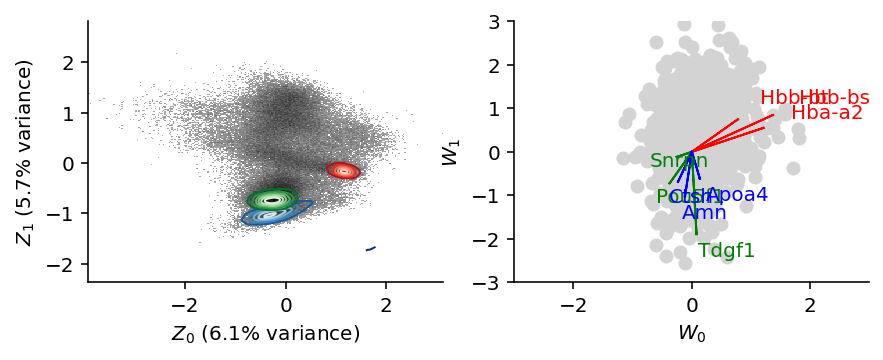

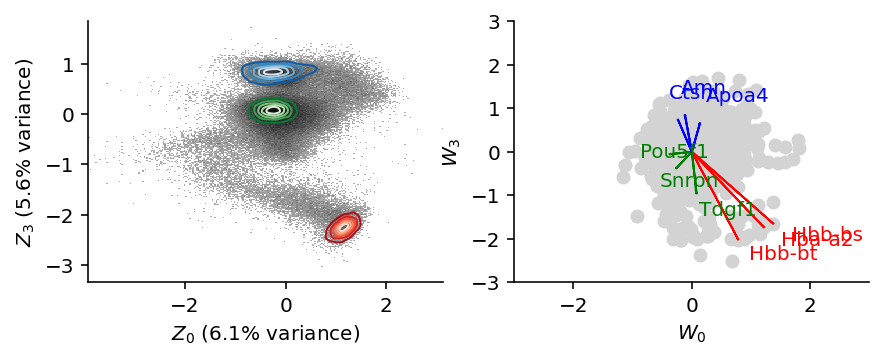

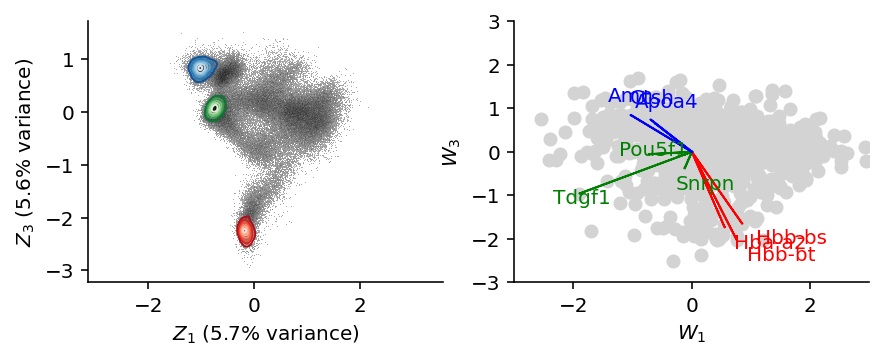

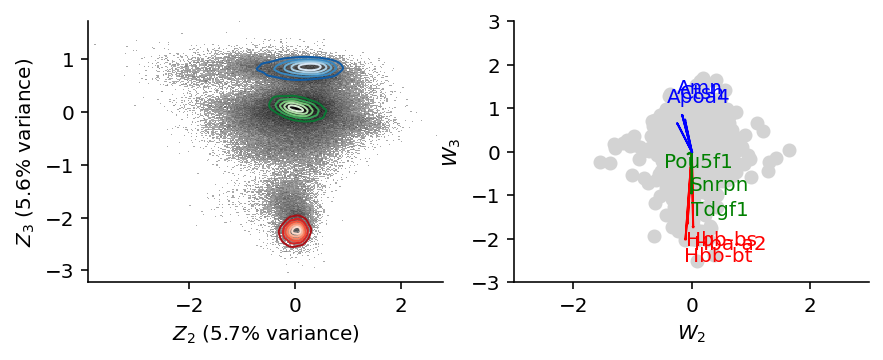

In [ ]:
for i in range(3):
    for j in range(i+1+(i%2),5,2):
        create_fig_0((i,j))

In [ ]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/download.zip /content/figures

# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/download.zip")

In [ ]:
figsize(80, 80)
z_length = 20
for i in range(z_length):
    for j in range(z_length):
        # -- Z plot --
    
        plt.subplot(z_length, z_length, z_length*i +j + 1)
        
        plt.hist2d(
            Z_df_ordered[f'z{i}'], Z_df_ordered[f'z{ j }'],
            bins=256,
            norm=mcolors.PowerNorm(0.25),
            cmap=cm.gray_r,
            rasterized=True
        )
        plt.axis('equal');
        plt.xlabel(f'$Z_{i}$ ({variance_explained[idx][i]:.1%} variance)')
        plt.ylabel(f'$Z_{j}$ ({variance_explained[idx][ j]:.1%} variance)')
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=20)

In [ ]:


text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}



['2610528A11Rik', 'Tdo2', 'Hoxc10', 'Hoxa10', 'Hoxa9', 'Tnnt2', 'Ptprc', 'Hoxc9']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Hoxa9', 'Tdgf1', 'Cdx4', 'Hoxb9', 'Hoxaas3', 'Hoxc8', 'Hoxa7', 'Eomes']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Pax6', 'Tal2', 'Hes3', 'Rax', 'Six3', 'Slc7a3', 'Dlx5', 'Lhx5']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Lum', 'Fezf1', 'Gal', 'Pax8', 'Wnt1', 'Tfap2b', 'En1', 'Sox10']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['1700011H14Rik', 'Utf1'

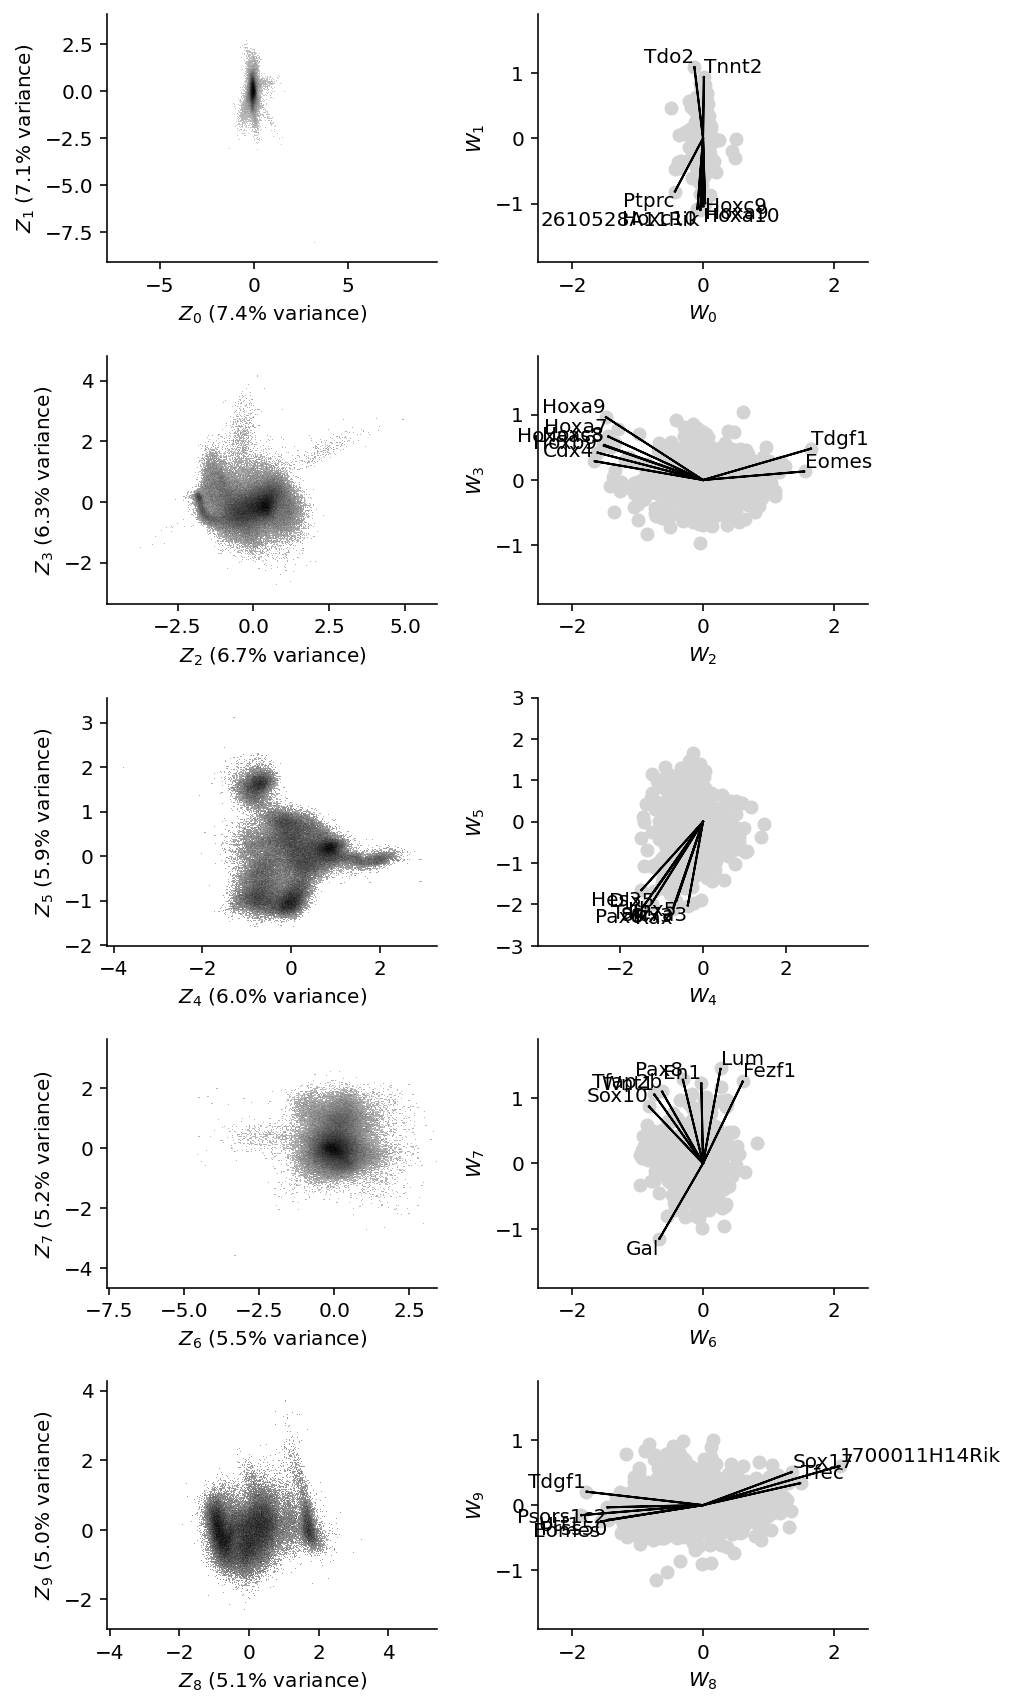

In [ ]:

figsize(7, 12)
for i in range(5):
    
    # -- Z plot --
    
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

    #plt.xlim(left=-3, right=3)
    #plt.ylim(bottom=-3, top=3)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)

In [ ]:
figsize(7, 12)
for i in range(5):
    
    # -- Z plot --
    
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    
    plt.subplot(5, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right'
        if x_ > 0:
            ha = 'left'
            
        va = 'top'
        if y_ > 0:
            va = 'bottom'
            
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True))
        
        xs, ys = 0, 0
        if (i, r.gene_name) in text_shift:
            xs, ys = text_shift[(i, r.gene_name)]
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)